# Importação de Bibliotecas e Carregamento dos Dados

Nesta etapa, importamos todas as bibliotecas necessárias para:

- Manipulação de dados (`pandas`)
- Visualização gráfica (`matplotlib` e `seaborn`)
- Divisão dos dados em treino e teste (`train_test_split`)
- Construção do modelo de Machine Learning (`RandomForestClassifier`)
- Avaliação do modelo (métricas como ROC-AUC e matriz de confusão)
- Salvamento e carregamento do modelo treinado (`joblib`)

Em seguida, carregamos o dataset já tratado localizado na pasta `processed`.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

# Definição das Variáveis

Aqui separamos:

- **X (features)** → Todas as variáveis explicativas
- **y (target)** → Variável alvo (`TARGET`)

Também removemos:
- `SK_ID_CURR` → identificador único (não agrega valor preditivo)
- `TARGET` → pois é a variável que queremos prever

Essa separação é essencial para o treinamento supervisionado.

Utilizamos `stratify=y` para manter a mesma proporção da variável alvo nos dois conjuntos, o que é especialmente importante em problemas desbalanceados (como inadimplência).

Dividimos os dados em:

- **70% para treino**
- **30% para teste**


In [12]:
df = pd.read_csv('../data/processed/application_train_final.csv')

x = df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y )
print(f'Tamanho do conjunto de treino: {X_train.shape}, Tamanho do conjunto de teste: {X_test.shape}')

Tamanho do conjunto de treino: (215257, 197), Tamanho do conjunto de teste: (92254, 197)


# Treinamento do Modelo - Random Forest

Nesta etapa:

- Criamos o modelo Random Forest com:
  - 200 árvores
  - Execução paralela para o processador trabalhar completamente(`n_jobs=-1`)
  - Sem ajuste de peso de classe inicialmente

- Treinamos o modelo usando os dados de treino.

Random Forest é um modelo baseado em múltiplas árvores de decisão, sendo robusto e eficiente para problemas tabulares.


In [ ]:
modelo_rf = RandomForestClassifier(n_estimators=200, random_state=42 , class_weight=None, n_jobs=-1)
print('Treinando o modelo Random Forest...')
modelo_rf.fit(X_train, y_train)

y_pred = modelo_rf.predict(X_test)


Treinando o modelo Random Forest...


# Avaliação Inicial - Matriz de Confusão (Threshold Padrão)

Aqui avaliamos o desempenho do modelo usando:

- Previsões diretas (`predict`)
- Matriz de confusão

A matriz de confusão nos mostra:

- Verdadeiros Positivos (TP)
- Verdadeiros Negativos (TN)
- Falsos Positivos (FP)
- Falsos Negativos (FN)

Ela permite analisar o tipo de erro que o modelo está cometendo.


Text(0.5, 1.0, 'Matriz de Confusão')

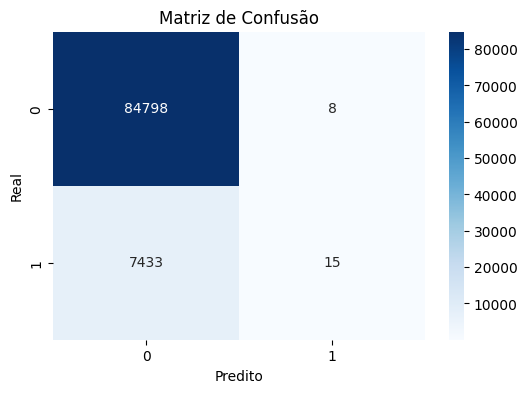

In [14]:
confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')

# Ajuste de Threshold

Em vez de usar o threshold padrão (0.5), definimos um novo threshold de 0.12.

Isso significa que classificamos como positivo qualquer probabilidade maior ou igual a 12%.

Esse ajuste é importante em problemas de crédito, onde pode ser mais interessante:

- Aumentar a sensibilidade (capturar mais inadimplentes)
- Reduzir falsos negativos

A nova matriz de confusão mostra o impacto dessa mudança.


Text(0.5, 1.0, 'Matriz de Confusão com Threshold de 0.10')

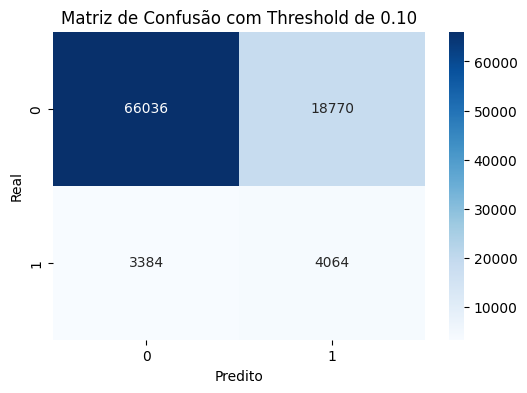

In [15]:
y_proba = modelo_rf.predict_proba(X_test)[:, 1]

threshold = .12

y_pred_threshold = (y_proba >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_threshold)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão com Threshold de 0.10')


# Métrica AUC-ROC

Calculamos o AUC-ROC (Área sob a curva ROC).

Essa métrica mede a capacidade do modelo de distinguir entre as classes.

- AUC = 0.5 → modelo aleatório
- AUC = 1.0 → modelo perfeito

É uma métrica ideal para problemas desbalanceados.


In [16]:
auc = roc_auc_score(y_test, y_proba)
print(f'AUC-ROC: {auc:.4f}')

AUC-ROC: 0.7266


# Importância das Variáveis

Extraímos as importâncias das features calculadas pelo Random Forest.

Selecionamos as 10 variáveis mais importantes para entender:

- Quais fatores mais influenciam a previsão de inadimplência
- Insights de negócio relevantes

Esse tipo de análise é extremamente importante para interpretabilidade.


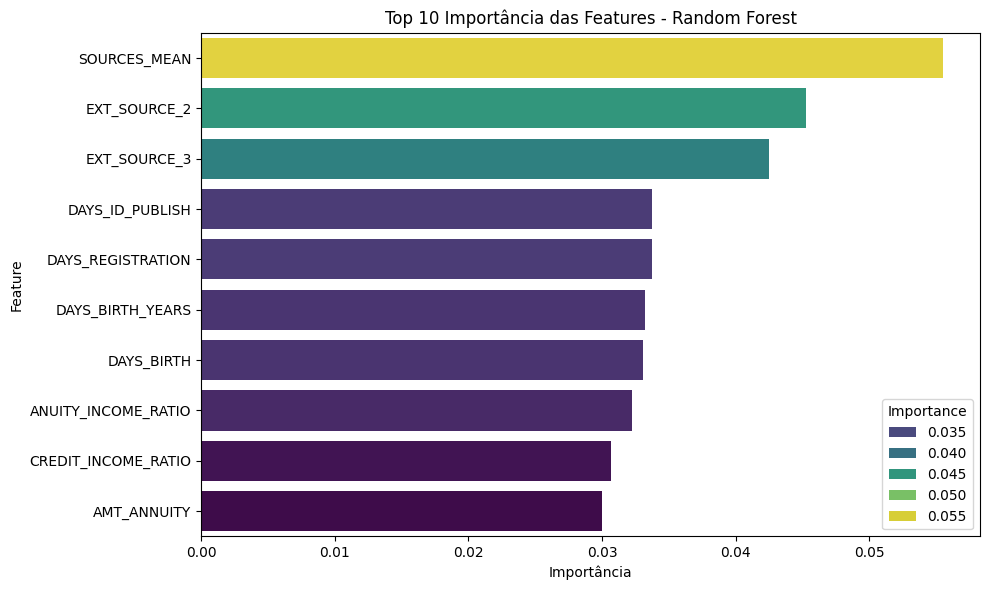

In [17]:

importances = modelo_rf.feature_importances_
columns = X_train.columns
df_importances = pd.DataFrame({'Feature': columns, 'Importance': importances}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importances, palette='viridis', hue='Importance', dodge=False)
plt.title('Top 10 Importância das Features - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Otimização de Hiperparâmetros (Grid Search)

Aqui definimos um grid de hiperparâmetros para buscar a melhor combinação possível.

Parâmetros testados:

- Número de árvores
- Profundidade máxima
- Critérios de divisão
- Peso das classes

Utilizamos validação cruzada (cv=3) e métrica ROC-AUC.

Essa etapa permite melhorar o desempenho do modelo de forma estruturada.

O modelo já treinado com o GridSearch está salvo na pasta "models".


In [18]:
"""
paramGrid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(estimator=modelo_rf, param_grid=paramGrid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
print('Iniciando Grid Search...')

grid_search.fit(X_train, y_train)

print(f'Melhores parâmetros: {grid_search.best_params_}')
print(f'Melhor AUC-ROC: {grid_search.best_score_:.4f}')
"""

"\nparamGrid = {\n    'n_estimators': [100, 200],\n    'max_depth': [None, 10, 20],\n    'min_samples_split': [2, 5],\n    'min_samples_leaf': [1, 2],\n    'class_weight': ['balanced', None]\n}\n\ngrid_search = GridSearchCV(estimator=modelo_rf, param_grid=paramGrid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')\nprint('Iniciando Grid Search...')\n\ngrid_search.fit(X_train, y_train)\n\nprint(f'Melhores parâmetros: {grid_search.best_params_}')\nprint(f'Melhor AUC-ROC: {grid_search.best_score_:.4f}')\n"

# Salvamento do Modelo Final

Após encontrar o melhor modelo via Grid Search, salvamos o modelo treinado utilizando `joblib`.

Isso permite:

- Reutilizar o modelo posteriormente
- Implantar em produção
- Evitar retrabalho


In [19]:
"""
modelo_final = grid_search.best_estimator_
joblib.dump(modelo_final, '../models/modelo_random_forest.pkl')
print('Modelo salvo com sucesso!')
"""

"\nmodelo_final = grid_search.best_estimator_\njoblib.dump(modelo_final, '../models/modelo_random_forest.pkl')\nprint('Modelo salvo com sucesso!')\n"

# Carregamento do Modelo Final e Avaliação

Carregamos o modelo salvo e:

- Calculamos novamente o AUC
- Geramos a Curva ROC

A Curva ROC mostra a relação entre:

- Taxa de Verdadeiros Positivos (TPR)
- Taxa de Falsos Positivos (FPR)

Quanto mais próxima do canto superior esquerdo, melhor o modelo.


In [20]:
modelo_final = joblib.load('../models/modelo_random_forest.pkl')
y_proba_final = modelo_final.predict_proba(X_test)[:, 1]
auc_final = roc_auc_score(y_test, y_proba_final)
print(f'AUC-ROC do modelo final: {auc_final:.4f}')

AUC-ROC do modelo final: 0.7432


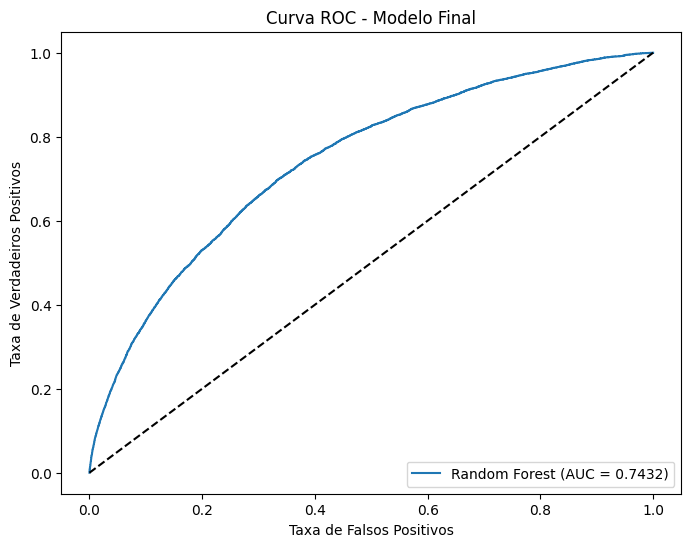

In [26]:
plt.figure(figsize=(8, 6))
auc_final = roc_auc_score(y_test, y_proba_final)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_final)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_final:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Modelo Final')
plt.legend(loc='lower right')
plt.show()
